<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S45_logistics_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook import logistics
from gtbook.display import show, pretty


# Planning for Logistics

> We will be planning in a discretized 2D state space, just like we did for the Markov localization state space.

<img src="Figures4/S45-Warehouse_robots-05.jpg" alt="Splash image with warehouse robot thinking" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

## Value Iteration in 2D

> It works, but can be slow.

Recall that value iteration starts with an initial guess, $V^0$, and at each iteration we update
our approximation of the value function by the update rule:

$$
V^{k+1}(x) \leftarrow \max_a \left\{ \bar{R}(x,a) + \gamma \sum_{x'} P(x'|x, a) V^k(x')   \right\}
= \max_a Q(x, a; V^k)
$$

This can be *very* expensive if applied naively, when the number of states is large. Indeed, if we use the 5000-state finite element discretization of the warehouse, the conditional probability table (CPT) above contains $5k \times 4 \times 5k = 100M$ entries.

There are ways to deal with this, computationally. Indeed, most transitions have zero probability, and hence we could store the CPT in a *sparse* multi-dimensional array instead. Alternatively, we can implement the Q value calculation as a *function*. This is what we will do below, and we will also immediately switch to using the 2D coordinates $(i,j)$ for the discretized cells:

In [4]:
goal = 35, 50
proximity = logistics.base_map + logistics.proximity_map_on

def Q_value(x, a, V):
    """Given a state x=(i,j) action a, and value image, calculate Q value."""
    i, j = x
    if x==goal: return 0 # only reward when *first* arriving at goal
    if logistics.base_map[i,j]: return 0 # invalid state
    if a == 0: next = (i,j-1) if j>0 else x # LEFT
    if a == 1: next = (i,j+1) if j<99 else x # RIGHT
    if a == 2: next = (i-1,j) if i>0 else x # UP
    if a == 3: next = (i+1,j) if i<49 else x # DOWN
    reward = 100 if next==goal else 0
    r, c = next
    if logistics.proximity_map_on[i,j]: reward -= 50 # in proximity is bad!
    if logistics.proximity_map_on[r,c]: reward -= 50 # as is going in proximity.
    return reward + 0.975 * V[r,c]

def update_V(x, V):
    """Given a state x=(i,j) and value image, calculate updated value."""
    Q_x = [Q_value(x, a, V) for a in range(4)]
    return max(Q_x)


Note above we assumed actions were *deterministic*, but the function can be easily adapted to non-deterministic actions. We awarded 100 points upon reaching the goal, but make sure that happens only once, or otherwise the value of that state will be infinite. In addition, when the state is near an obstacle (we use the `proximity_map_on` likelihood image from Section 4.3), the agent gets punished by 100 points. Below, we do value iteration using a brute force loop, which is still remarkably fast:

In [5]:
%%time
I, J = np.meshgrid(range(50), range(100), indexing='ij')
states = np.dstack((I, J)).reshape(5000,2)
k = 0
V_k = np.full((50,100), 0.0)
error = float('inf')
while error>1e-5:
    V_plus = np.empty((50,100), float)
    for i,j in states:
        V_plus[i,j] = update_V((i,j), V_k)
    error = np.max(np.abs(V_plus-V_k))
    V_k = V_plus
    k += 1
print(f"after {k} iterations, error = {error}")


after 86 iterations, error = 0.0
CPU times: user 1.95 s, sys: 15.4 ms, total: 1.97 s
Wall time: 1.99 s


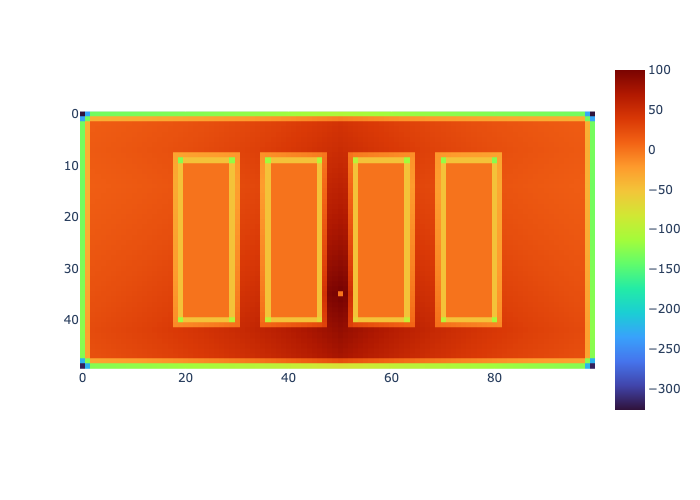

In [6]:
px.imshow(V_k, color_continuous_scale='Turbo',origin="upper", aspect='equal')


Notice that the *gradient* of the value function determines the optimal policy: at any cell, we can just look around in all 4 directions and move to the cell with the largest value.

### Thought Exercise

Why might the algorithm terminate after 86 iterations?

## The Intuition behind Value Iteration

> Costs and rewards propagate.

It is instructive to look at an animation for how the value function evolves in successive iterations of the value iteration algorithm:

<figure id="fig:value">
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/value.gif?raw=1" style="width:14cm" alt="">
<figcaption>The <b>value iteration</b> algorithm, animated.</figcaption>
</figure>

The most prominent phenomenon that one can make out in the animation above is that the reward from reaching the goal state, in the middle of the warehouse, gradually propagates towards every location. It gradually decreases in value because of the discount factor. It also does not penetrate the obstacles in the map, because those states simply have a value of zero.

There is a deep connection between value iteration and the all-sources-shortest-path algorithm that you might have seen in an algorithms class.
Deterministic actions set up a graph, and while in this case we have no penalty to moving in the the graph, the discount factor plays the same role in practice.
In fact, if we set the discount factor to zero and give actions a cost, both algorithms will return identical results.

## Closing the Loop

> Adding a state estimator closes the sense-think-act loop.

We sense, estimate our state, and execute a policy. We can take any of the algorithms from the last section and use them to estimate our current state. The value function gives us a policy, which can then execute. After that, we recurse.

To calculate the policy, you should take into account the uncertainty in actions. The policy we calculated above for the warehouse is not optimal, because we assumed deterministic actions in the calculation of the Q values. In Section 3.5 we saw how to account for uncertain, Gaussian actions, so that would yield a better policy. In particular, we will be more cautious and stay even further away from obstacles, as we know that the robot does not always perfectly executes our commands.

### Thought Exercise

Estimating a single location for the robot is not always possible: posterior densities can be *multi-modal*, and so do not know any better than that we are in a number of possible locations. What should we do in that case?

## Partially Observable MDPs

> POMDP = Planning to sense!

To *really* calculate the optimal policy, we would need to know how acting will affect our sensing. Even when we take into account the uncertainty in the actions, there is something we have not taken into account: uncertain *sensing*. Indeed, when calculating the optimal policy we have assumed that we have perfect knowledge of the state. The framework in which to think about uncertain sensing is called **partially observable Markov decision processes**, or POMDPs. 

While out of scope for this book, it is important to be aware of this limitation of the MDP framework. A POMDP policy could improve on this by planning to sense: for example, we could be we could move closer to an RFID beacon on purpose, to re-localize the robot when we are not very certain about its location. 

POMDPs are computationally incredibly expensive, because the state is no longer simply *where* we are, but also *what we believe* the state is. Hence, POMDPs are about planning in the *belief states*, which is a very high-dimensional concept.